In [1]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pandas import read_csv
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [2]:
ibc_df = read_csv("merged_ibc_with_redshift.csv")
ia_df = read_csv("merged_modelpar_Ia_with_redshift.csv")

In [3]:
ibc_df.head()

,object_id,true_z,submodel,sim_av,IBC_INDEX,Mejecta,Kinetic_energy,F_nickel
0,268,0.621,2,0.1007,569,4.0460,1.3293,0.0744
1,1304,0.309,2,0.8308,577,6.1297,2.4682,0.0565
2,1660,0.817,2,0.0018,670,9.8119,4.1647,0.0849
3,2407,0.586,2,0.0108,500,1.1125,7.1842,0.0801
4,3073,0.441,2,0.2936,395,2.0126,3.4670,0.0448


In [57]:
class ArnettSource(sncosmo.Source):

    _param_names = ['texp', 'mej', 'fni', 'vej']
    param_names = ['texp', 'mej', 'fni', 'vej']

    param_names_latex = ['t_{exp}', 'M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift,  params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        # self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, theta):
        texp, mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        mni = mej * fni
        # Convert velocity to cm/s
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day

        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
        # print(mej.to(u.Msun), vej, td)
        # if td < 3. * u.day:
        #     td = 3. * u.day
        # print(td)

        # use a denser time array for better integration
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points

        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        # fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        
        fluxes = self._blackbody_flux(temperature, radius, wvs / (1 + redshift)) # this is a luminosity density

        fluxes[t < texp,:] = 0.* u.kg *u.m / u.s**3

        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density / (1 + redshift)


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._parameters)

In [58]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# zeropoints from https://smtn-002.lsst.io/
zeropoints = [28.51, 28.36, 28.17, 27.78]
# LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# LSST observing parameters (from official LSST specs)
exptime = 30.0  # seconds per visit (2x15s exposures)
pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
read_noise = 8.8  # electrons per pixel per exposure
dark_current = 0.2  # electrons per pixel per second
num_bands = len(bands)

# Convert sky brightness to sky noise (electrons/pixel/second)
# Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# For now, using approximate values - these should be calculated more precisely
sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})

ibc_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})



In [59]:
def simulate_ibc(true_z, texp, mej, fni, vej):
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[mej, fni, vej])
    arnett_source = ArnettSource(times, wavelengths, true_z, params=[texp, mej, fni, vej])

    
    arnett_model = sncosmo.Model(source=arnett_source)
    params = {'texp': texp, 'mej': mej, 'fni': fni, 'vej': vej}

    lcs = sncosmo.realize_lcs(ibc_obs, arnett_model, [params])
    
    r_band_mask = lcs[0]['band'] == 'lsstr'

    
    # calculate SNR in r band
    # snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    # print("SNR:", snr)
    # mej = (mej * u.Msun).to(u.g)
    # vej = vej * u.km/u.s
    # opac = 0.1 *u.cm * u.cm/u.g        

    # Diffusion timescale in days
    # td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
    # print(td)
    # lcs[0]['flux'][lcs[0]['flux'] <= 0] = 0.1
    return lcs

4.075342659038505


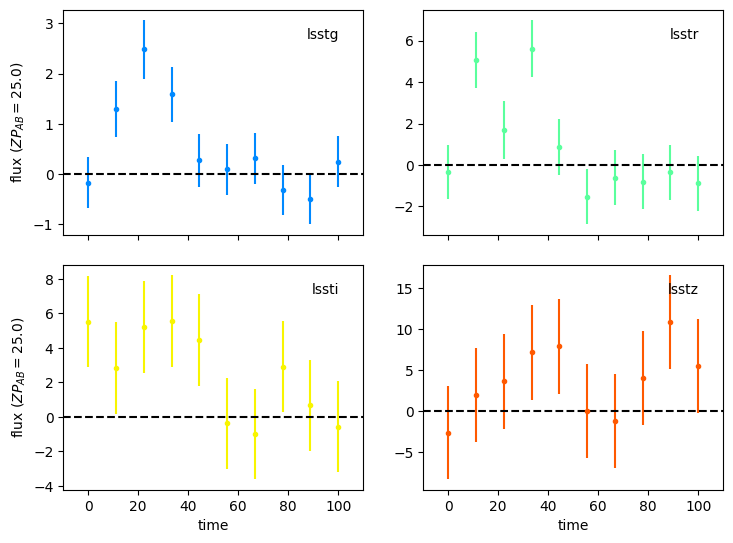

In [60]:
# light_curve = simulate_ibc(0.05, 0, 3, 0.1, 10000)
# light_curve = simulate_ibc(0.116, 5.76, 0.4841, 0.0309, 37270.73384139233)
# light_curve = simulate_ibc(0.116, 2.4, 0.4841, 0.0309, 37270.73384139233)

light_curve = simulate_ibc(0.18, 0, 5.4863 , 0.0456, 10416.298485236222)
r_band_mask = light_curve[0]['band'] == 'lsstr'
print(np.max(light_curve[0]["flux"][r_band_mask] / light_curve[0]["fluxerr"][r_band_mask]))


sncosmo.plot_lc(light_curve[0]);

In [61]:
def get_texp_guess(light_curve):
    max_index = np.argmax(light_curve[0]['flux'][light_curve[0]['band'] == 'lssti'])
    print(max_index)
    max_time = (light_curve[0]['time'][light_curve[0]['band'] == 'lssti'])[max_index]
    print((light_curve[0]['time'][light_curve[0]['band'] == 'lssti']))
    print(max_time)
    return max_time - 5.

In [62]:
def fit_ibc(true_z, lcs):

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 3, 0.05, 15000]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 0.5, 0.1, 20000]) # initial parameter values? not sure why these are needed...
        arnett_model = sncosmo.Model(source=arnett_source)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [63]:
def td(mej, vej):
    mej = (mej * u.Msun).to(u.g)
    vej = vej * u.km/u.s
    # Diffusion timescale in days
    opac = 0.1 *u.cm * u.cm/u.g        
    td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day) 
    return td

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...


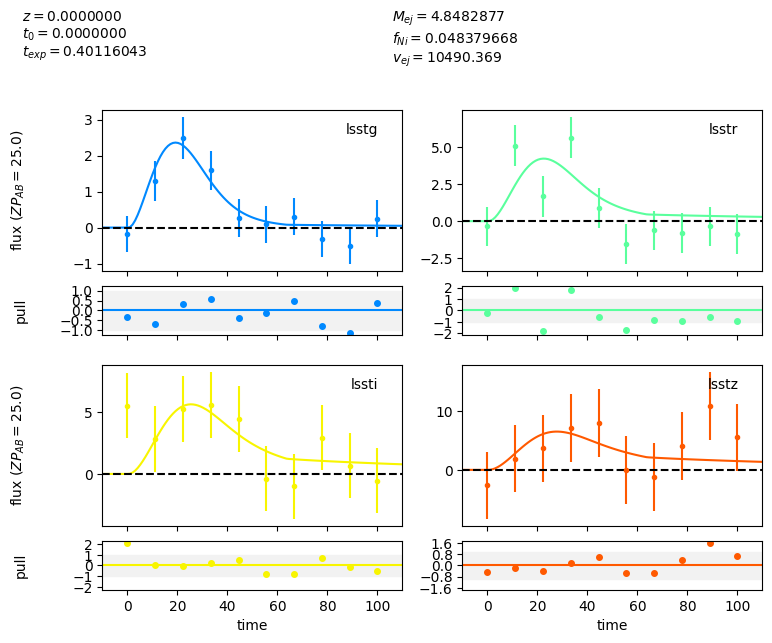

In [64]:
result, fitted_model = fit_ibc(0.18, light_curve)
sncosmo.plot_lc(light_curve[0], model=fitted_model);

In [65]:
num_to_fit = 10
fits = {'true_z': [], 'true_texp': [], 'true_mej': [], 'true_fni': [], 'true_vej':[], 'fit_texp':[], 'fit_mej':[], 'fit_fni':[], 'fit_vej':[]}

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = ((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)
    
    this_texp = np.random.uniform(0., 7.)
    # if true_z > 0.2 or vej.value > 20000:
    #     continue
    
    try:
        lcs = simulate_ibc(true_z, this_texp, mej, fni, vej.value)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("Wrong SNR:", peak_snr)
            continue
        print("SNR:", peak_snr)
        # sncosmo.plot_lc(lcs[0])

        result, fitted_model = fit_ibc(true_z, lcs)
        # sncosmo.plot_lc(lcs[0], model=fitted_model)
        # plt.show()
        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_texp'].append(this_texp)
        fits['true_mej'].append(mej)
        fits['true_fni'].append(fni)
        fits['true_vej'].append(vej.value)
        fits['fit_texp'].append(result_dict['texp'])
        fits['fit_mej'].append(result_dict['mej'])
        fits['fit_fni'].append(result_dict['fni'])
        fits['fit_vej'].append(result_dict['vej'])
    except Exception as e:
        print(e)

    if len(fits['fit_mej']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

Wrong SNR: 2.4128174505786166
Wrong SNR: 1.8448252895161077
Wrong SNR: 1.6610676952120298
Wrong SNR: 1.8198759080685027
Wrong SNR: 0.17905695699764587
Wrong SNR: 1.4074309833393401
Wrong SNR: 3.694081279315552
Wrong SNR: 1.2798461246766546
Wrong SNR: 0.9847040389023148
Wrong SNR: 1.8059634119461605
Wrong SNR: 0.8094160892730635
Wrong SNR: 0.5197275561853133
Wrong SNR: 1.0387986400050584
Wrong SNR: 3.71822129392611
Wrong SNR: 1.9149796033208792
Wrong SNR: 1.8955347664120343
Wrong SNR: 0.9982694228179492
Wrong SNR: 1.6838633255759319
Wrong SNR: 1.2997015911364849
Wrong SNR: 2.3180042282600093
Wrong SNR: 1.466848407349287
Wrong SNR: 1.911390648858056
Wrong SNR: 1.3892980988620893
Wrong SNR: 1.1304154672372368
Wrong SNR: 2.42034484384931
Wrong SNR: 1.367418650864774
Wrong SNR: 2.7358466261782297
Wrong SNR: 1.3678971374109243
Wrong SNR: 1.6118096458815567
Wrong SNR: 1.8728055226102027
Wrong SNR: 2.0356917099119447
Wrong SNR: 2.618502293169783
Wrong SNR: 0.7351005471853282
Wrong SNR: 2.22388

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:377: RuntimeWarning: overflow encountered in add
  res = np.cumsum(d * (y[slice1] + y[slice2]) / 2.0, axis=axis)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Wrong SNR: 1.4763001476116557
Wrong SNR: 1.4769280667321654
Wrong SNR: 0.9085836074145809
Wrong SNR: 1.92098970204531
Wrong SNR: 1.650174285222921
Wrong SNR: 1.5191942216596683
Wrong SNR: 1.111656089328683
Wrong SNR: 2.8051310638962668
Wrong SNR: 2.62936469070827
Wrong SNR: 2.458261784096216
Wrong SNR: 0.7390298072775273
Wrong SNR: 1.3431461812821517
Wrong SNR: 1.4465125437609805
Wrong SNR: 2.4567670424368
Wrong SNR: 1.666989966536291
Wrong SNR: 2.4259344824423
Wrong SNR: 1.1889542340576789
Wrong SNR: 1.7302641277402062
Wrong SNR: 1.7948336353170078
Wrong SNR: 1.8409784026488236
Wrong SNR: 0.8115138145919797
Wrong SNR: 1.1735120115656679
Wrong SNR: 2.0565920270497937
Wrong SNR: 3.2768230772694826
Wrong SNR: 2.784452085880165
Wrong SNR: 1.2224590508166906
Wrong SNR: 2.102784876856301
Wrong SNR: 1.0927264630479994
Wrong SNR: 1.7883599032682533
Wrong SNR: 1.0655088855921042
Wrong SNR: 1.3474383549354174
Wrong SNR: 2.0789341789285145
Wrong SNR: 1.7324769963714897
Wrong SNR: 1.8526293463461

Text(0, 0.5, 'Fit texp')

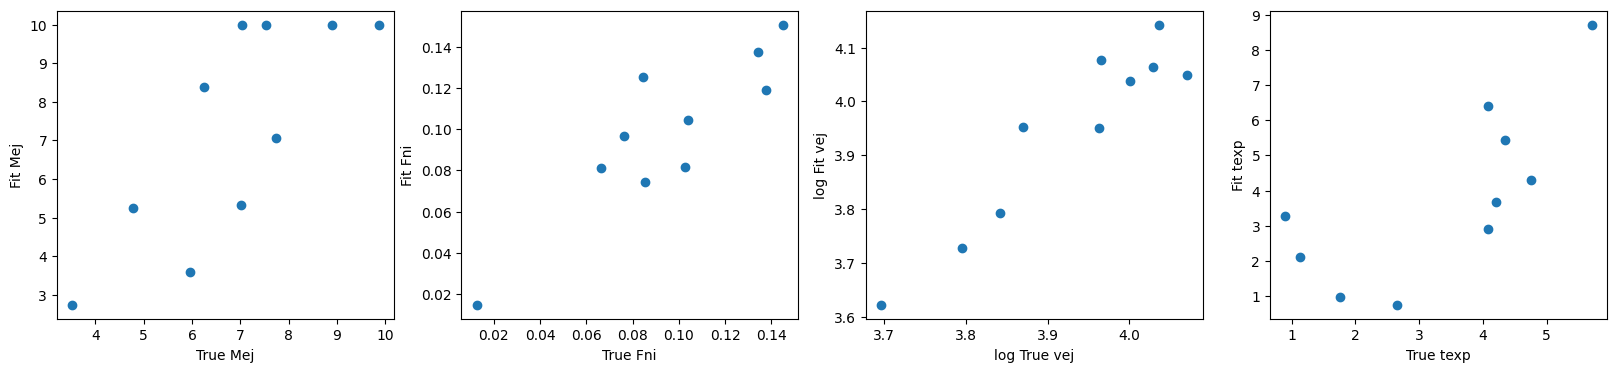

In [66]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))

ax[0].plot(fits['true_mej'], fits['fit_mej'], 'o')
ax[0].set_xlabel("True Mej")
ax[0].set_ylabel("Fit Mej")
ax[1].plot(fits['true_fni'], fits['fit_fni'], 'o')
ax[1].set_xlabel("True Fni")
ax[1].set_ylabel("Fit Fni")
ax[2].plot(np.log10(fits['true_vej']), np.log10(fits['fit_vej']), 'o')
ax[2].set_xlabel("log True vej")
ax[2].set_ylabel("log Fit vej")
ax[3].plot(fits['true_texp'], fits['fit_texp'], 'o')
ax[3].set_xlabel("True texp")
ax[3].set_ylabel("Fit texp")

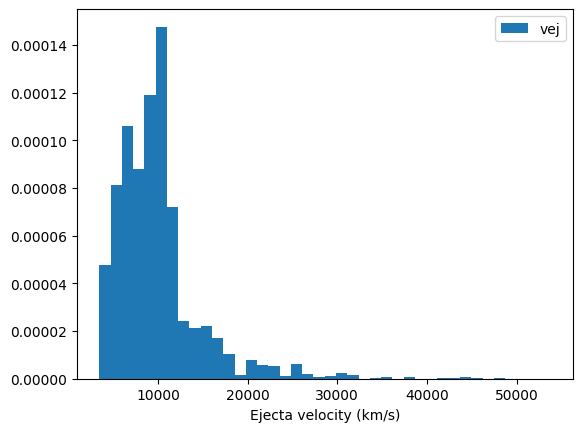

In [67]:
vej = np.sqrt(
    2 * ibc_df['Kinetic_energy'].values * 1e51 * u.erg / (ibc_df['Mejecta'].values * u.Msun)
)
vej = vej.to(u.km / u.s)
plt.hist(vej.value, bins=40, density=True, label="vej")
plt.xlabel("Ejecta velocity (km/s)")
plt.legend()


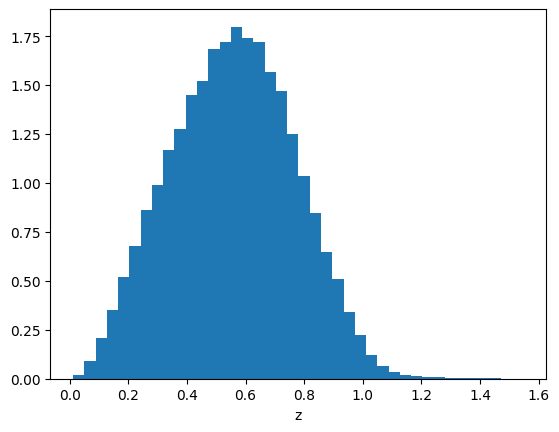

In [68]:
plt.hist(ia_df['true_z'].to_numpy(), bins=40, density=True)
plt.xlabel("z")
plt.show()

In [69]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [70]:
get_x0(np.min(ia_df['salt2_mb'].to_numpy())), get_x0(np.max(ia_df['salt2_mb'].to_numpy()))

(0.047363086913163675, 7.842959998847406e-07)

In [71]:
np.min(ia_df['salt2_color'].to_numpy()), np.max(ia_df['salt2_color'].to_numpy())

(-0.2673, 0.3732)

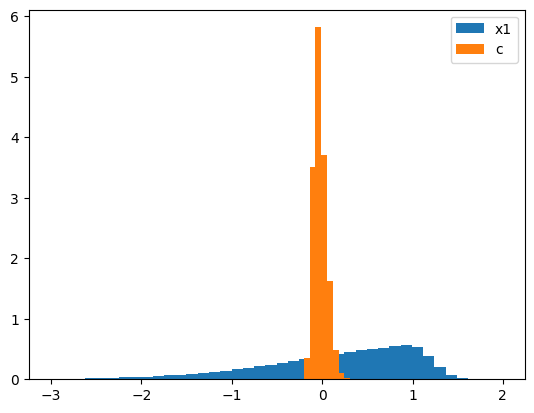

In [72]:
plt.hist(ia_df['salt2_x1'].to_numpy(), bins=40, density=True, label="x1")
plt.hist(ia_df['salt2_color'].to_numpy(), density=True, label="c")
plt.legend()

In [89]:
def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    
    this_ia_model = sncosmo.Model(source=ia_source)

    lcs = sncosmo.realize_lcs(ia_obs, this_ia_model, [params])
    # r_band_mask = lcs[0]['band'] == 'lsstr'
    # snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    # print("SNR:", snr)

    return lcs

In [95]:
def fit_ia(true_z, lcs):

    # this_ia_model = sncosmo.Model(source='salt2')
    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [96]:
# light_curve = simulate_ia(0.624, 20, get_x0(23.7568), -0.3504, 0.0744)
light_curve = simulate_ia(0.2, 20, get_x0(23.7568), -0.3504, 0.0744)

3.4522012396995296


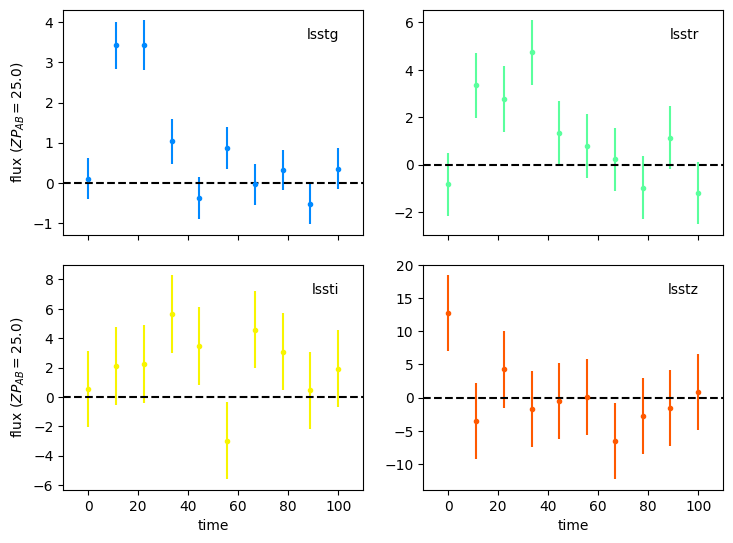

In [97]:
sncosmo.plot_lc(light_curve[0]);
print(np.max(light_curve[0]["flux"][r_band_mask] / light_curve[0]["fluxerr"][r_band_mask]))



/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


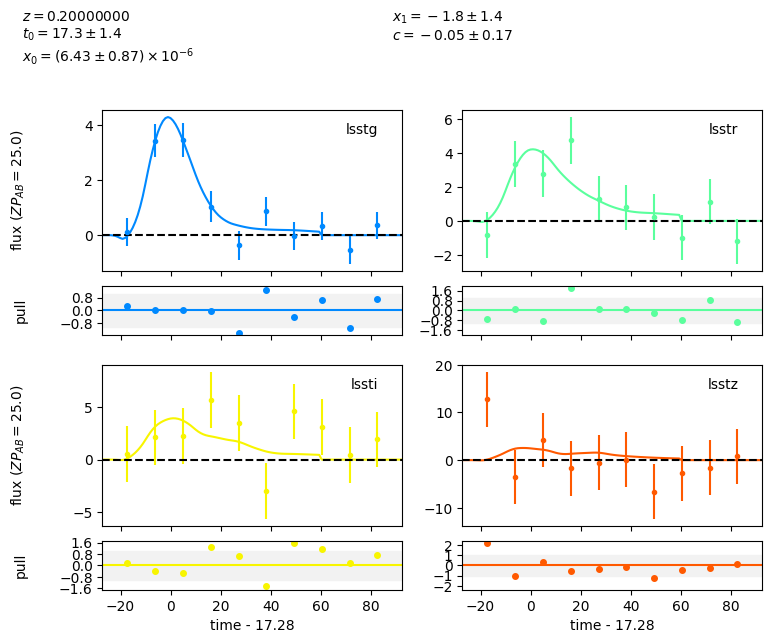

In [98]:
ia_result, ia_fitted_model = fit_ia(0.2,light_curve)
# ibc_result, ibc_fitted_model = fit_ibc(0.274,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

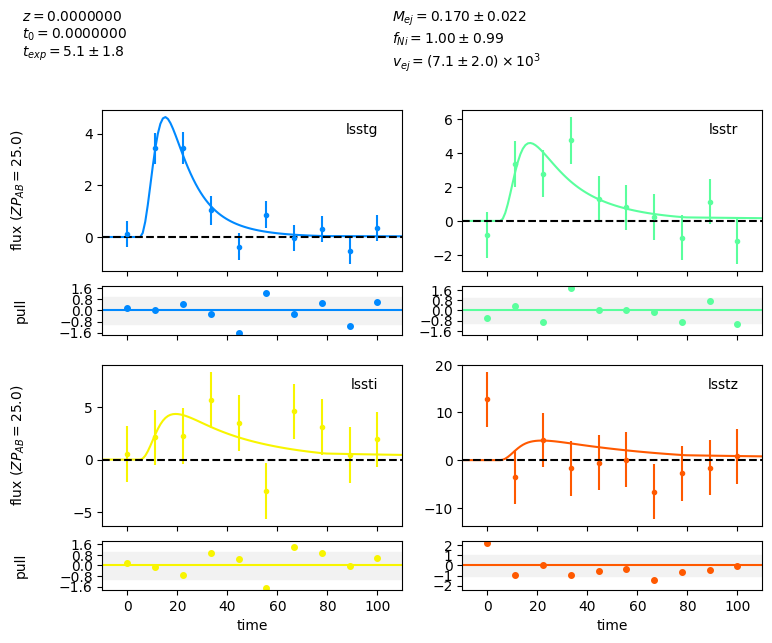

In [99]:
ibc_result, ibc_fitted_model = fit_ibc(0.2,light_curve)
# ibc_result, ibc_fitted_model = fit_ibc(0.274,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

34.78898635968799


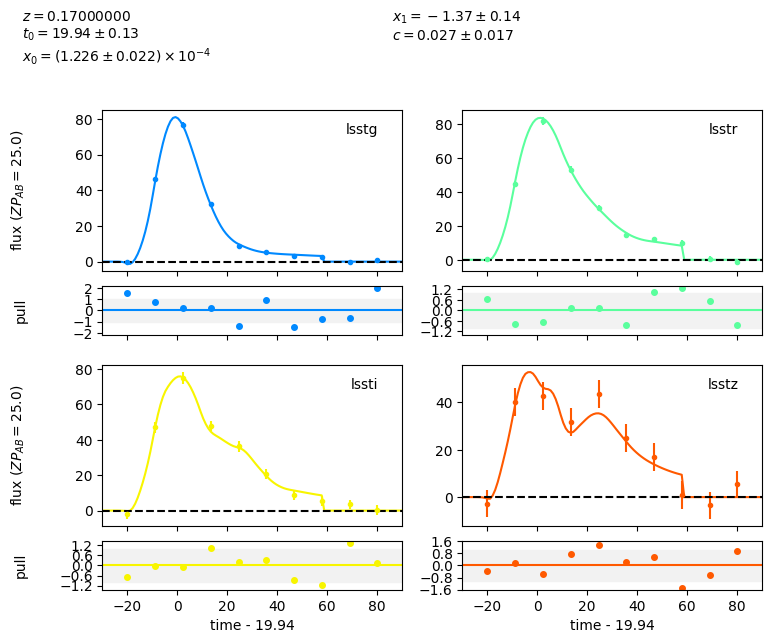

In [100]:
light_curve = simulate_ia(0.17, 20, get_x0(20.3969), -1.3166, 0.0048)
print(np.max(light_curve[0]["flux"][r_band_mask] / light_curve[0]["fluxerr"][r_band_mask]))
ia_result, ia_fitted_model = fit_ia(0.17,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

In [101]:
light_curve

[<Table length=40>
        time         band        flux             fluxerr          zp   zpsys
      float64        str5      float64            float64       float64  str2
 ------------------ ----- ------------------ ------------------ ------- -----
               0.01 lsstg -3.506026511618348 13.653416647422825   28.51    ab
              11.12 lsstg 1169.8401861577238  36.45428597194729   28.51    ab
              22.23 lsstg 1939.2602997938213  46.28325739712709   28.51    ab
 33.339999999999996 lsstg  811.6501719795726 31.589427069047073   28.51    ab
 44.449999999999996 lsstg 220.23799728266584 20.543941427488253   28.51    ab
 55.559999999999995 lsstg 142.80590665194683 17.160458243666792   28.51    ab
              66.67 lsstg  74.47639732747061 16.248857870782487   28.51    ab
              77.78 lsstg  68.22928091563274 15.654412871970083   28.51    ab
              88.89 lsstg -8.329603653287068 12.766151420403075   28.51    ab
              100.0 lsstg   25.5002454422479 

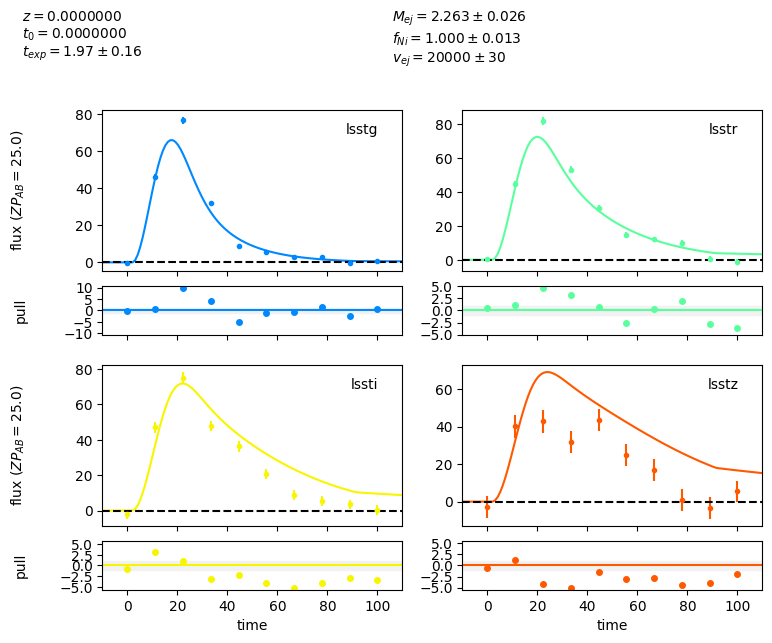

In [102]:
ibc_result, ibc_fitted_model = fit_ibc(0.17,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

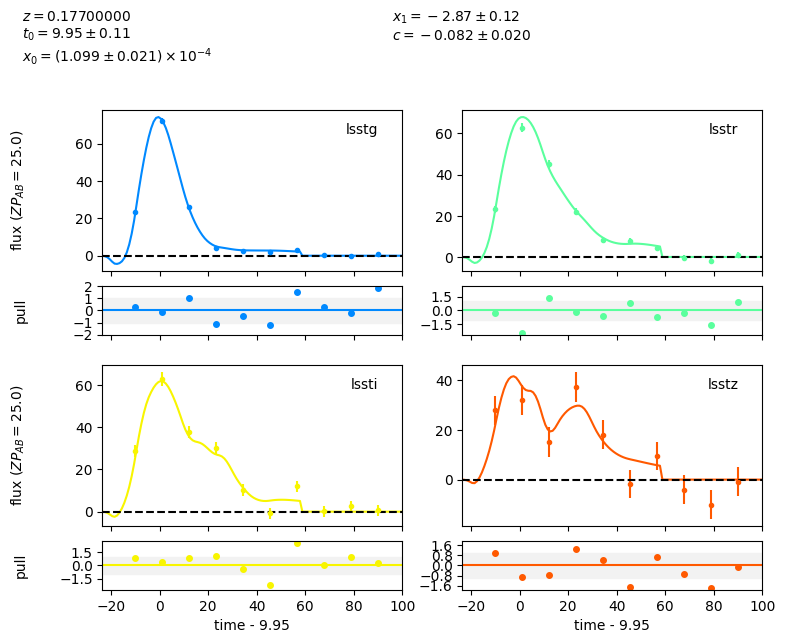

In [103]:
light_curve = simulate_ia(0.177, 10, get_x0(20.5669), -2.872, -0.0432)
ia_result, ia_fitted_model = fit_ia(0.177,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

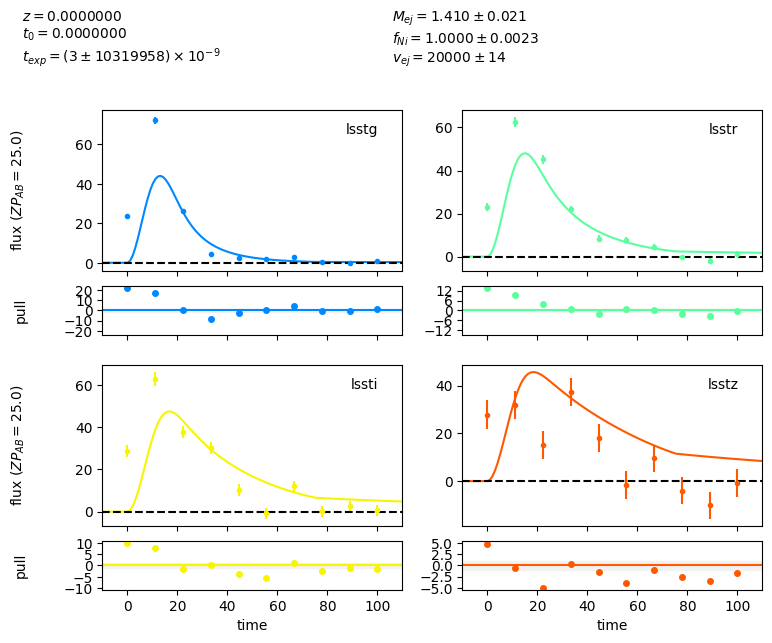

In [104]:
ibc_result, ibc_fitted_model = fit_ibc(0.177,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

In [105]:
num_to_fit = 100

bad_count = 0
good_count = 0

fits = {'true_z': [], 'true_t0': [], 'true_x0': [], 'true_x1':[], 'true_c':[], 'fit_t0':[], 'fit_x0':[], 'fit_x1':[], 'fit_c':[]}

# t0 = 20

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    
    # if true_z > 0.2:
    #     continue
    try:
        this_t0 = np.random.normal(14., 7.)
        # print(true_z, this_t0)
        lcs = simulate_ia(true_z, this_t0, x0, x1, c)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("Bad SNR:", peak_snr)
            bad_count += 1
            continue
        print("OK SNR:", peak_snr)
        good_count += 1

        result, model = fit_ia(true_z, lcs)

        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_t0'].append(this_t0)
        fits['true_x0'].append(x0)
        fits['true_x1'].append(x1)
        fits['true_c'].append(c)
        fits['fit_t0'].append(result_dict['t0'])
        fits['fit_x0'].append(result_dict['x0'])
        fits['fit_x1'].append(result_dict['x1'])
        fits['fit_c'].append(result_dict['c'])
    except:
        print(true_z, "Did not work")

    if len(fits['fit_x0']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)
print("Good fits:", good_count, "Bad fits:", bad_count)

Bad SNR: 3.785914678850971
OK SNR: 9.683770223335735
Bad SNR: 2.266708052834485
Bad SNR: 2.3984633242951587
Bad SNR: 2.044486157484648
Bad SNR: 1.7162655953148014
Bad SNR: 1.4398629024035199
Bad SNR: 18.81124294333222
Bad SNR: 2.9873269093488637
OK SNR: 6.931335046648511
Bad SNR: 3.078296703252853
Bad SNR: 11.781424979147229
OK SNR: 7.846102846960107
Bad SNR: 2.4120493721221745
Bad SNR: 4.223845242968277
Bad SNR: 2.674704870096127
Bad SNR: 2.2542154312286917
Bad SNR: 1.8068785584714913
Bad SNR: 1.5837237755174678
Bad SNR: 3.286469590707783
Bad SNR: 3.0473881362267985
Bad SNR: 4.672210077827068
OK SNR: 9.49134204710323
Bad SNR: 0.9951700880340406
OK SNR: 9.721138676908915
Bad SNR: 1.1701083359075608
Bad SNR: 1.8284832523642713
Bad SNR: 1.1263931428918348
Bad SNR: 2.2558984077420154
Bad SNR: 1.0022983584900655
Bad SNR: 11.602687020442923
OK SNR: 6.637658762325416
Bad SNR: 2.230553886862319
OK SNR: 5.096621319844715
OK SNR: 5.03835997234371
Bad SNR: 2.1216927522755684
Bad SNR: 1.721642090

Text(0, 0.5, 'Fit t0')

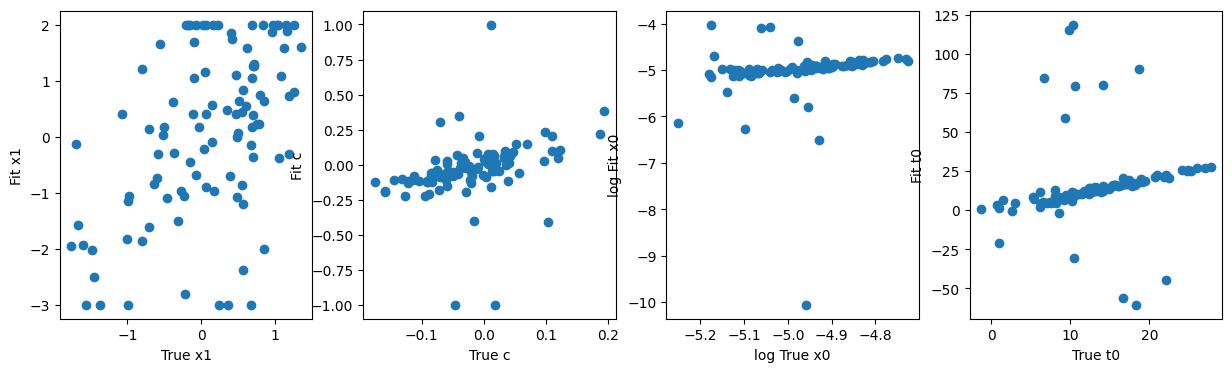

In [106]:
fig, ax = plt.subplots(1,4, figsize=(15, 4))

ax[0].plot(fits['true_x1'], fits['fit_x1'], 'o')
ax[0].set_xlabel("True x1")
ax[0].set_ylabel("Fit x1")
ax[1].plot(fits['true_c'], fits['fit_c'], 'o')
ax[1].set_xlabel("True c")
ax[1].set_ylabel("Fit c")
ax[2].plot(np.log10(fits['true_x0']), np.log10(fits['fit_x0']), 'o')
ax[2].set_xlabel("log True x0")
ax[2].set_ylabel("log Fit x0")
ax[3].plot(fits['true_t0'], fits['fit_t0'], 'o')
ax[3].set_xlabel("True t0")
ax[3].set_ylabel("Fit t0")

In [107]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
            


In [108]:
SN('ia', {'z':0.6, 't0':20, 'x0':1e-5, 'x1':0.1, 'c':0.1}).true_class

'ia'

In [109]:
num_to_fit = 100

# t0 = 20
bad_count = 0
good_count = 0

true_ia_sne = []

# fit true Ias as both
start = time.time()
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    # if true_z > 0.2:
    #     continue
    
    try:
        this_t0 = np.random.normal(14., 7.)
        # print(true_z, this_t0)
        
        true_dict = {'z': true_z, 't0':this_t0, 'x0':x0, 'x1':x1, 'c':c}
        this_sn = SN('ia', true_dict)

        lcs = simulate_ia(true_z, this_t0, x0, x1, c)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("Bad SNR:", peak_snr)
            bad_count += 1
            continue
        print("OK SNR:", peak_snr)
        good_count += 1

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)
        # print(sncosmo.flatten_result(ibc_result))
        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))

        true_ia_sne.append(this_sn)
    except Exception as e:
        print(e)

    if len(true_ia_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)
print("Good fits:", good_count, "Bad fits:", bad_count)


Bad SNR: 3.6692062625028727
Bad SNR: 10.022308296581407
Bad SNR: 2.438626446983585
Bad SNR: 0.8202313563887773
Bad SNR: 2.6554346537514575
Bad SNR: 1.301966304871629
Bad SNR: 1.328273000838111
Bad SNR: 19.48634325869762
Bad SNR: 1.9137625809732082
OK SNR: 7.1546519743830945
Bad SNR: 2.5630126806349667
Bad SNR: 10.57525537799557
OK SNR: 8.100320054054832
Bad SNR: 3.496561701947487
Bad SNR: 4.780102782008596
Bad SNR: 1.8368049183822734
Bad SNR: 3.5009053694151437
Bad SNR: 0.8425227649202499
Bad SNR: 2.1321957057918324
Bad SNR: 4.667414390493594
Bad SNR: 3.3990450049036522
Bad SNR: 4.703474105359374
OK SNR: 9.882676592040596
Bad SNR: 2.1399840651991493
OK SNR: 5.83254266979121


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
Bad SNR: 1.789293134679893
Bad SNR: 2.02946290299605
Bad SNR: 1.9197313202137818
Bad SNR: 2.4496085490104216
Bad SNR: 1.082500599637817
Bad SNR: 12.578315951476812
Bad SNR: 4.040134856539103
Bad SNR: 1.3826843747205504
Bad SNR: 4.98960806173458
OK SNR: 7.081590122116368
Bad SNR: 2.8280843804559144
Bad SNR: 1.5149539335723359
Bad SNR: 1.0114280947399903
Bad SNR: 13.598597651111305
Bad SNR: 1.1796052207542898
Bad SNR: 2.1747977227126065
Bad SNR: 3.3236208840785513
Bad SNR: 3.9244967235477217
OK SNR: 7.410601722800264
Bad SNR: 1.9612727085276702
Bad SNR: 2.3320101730964167
Bad SNR: 0.654011296870055
Bad SNR: 1.9971932055529937
Bad SNR: 2.742104241307598
Bad SNR: 2.472623673434576
OK SNR: 6.557937674358096
Bad SNR: 1.9508043158656172
Bad SNR: 0.8064653297432951
Bad SNR: 0.8953288965499252
Bad SNR: 1.8730437611194575
Bad SNR: 3.1678980216925163
Bad SNR: 1.4265233274744158
Bad SNR: 1.5224394518483548
Bad SNR: 1.7966531164570207
Bad SNR: 1.9810896657829795
Bad SNR: 1.679255176

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
Bad SNR: 1.8146671787055912
Bad SNR: 1.6721565865456378
Bad SNR: 2.341832304675808
Bad SNR: 3.3011071605314135
Bad SNR: 1.065798070173171
Bad SNR: 3.9357685350965452
Bad SNR: 3.732874455186203
Bad SNR: 1.1901505508453993
Bad SNR: 1.0589388921933267
OK SNR: 5.1575740576433
Bad SNR: 1.3212507002037321
bandpass 'lsstg' [3866, .., 5670] outside spectral range [3876, .., 56977.2]
Bad SNR: 1.243683450894554
Bad SNR: 2.502742094089627
Bad SNR: 0.7452380893020281
Bad SNR: 1.8092585327028274
OK SNR: 8.04242237799977
Bad SNR: 2.539817750331298
Bad SNR: 3.457053104216662
Bad SNR: 1.5695666199014302
Bad SNR: 12.490214606835012
OK SNR: 8.142865696408622
Bad SNR: 1.9393615264211974
Bad SNR: 3.738585918605176
Bad SNR: 2.7649834367882327
bandpass 'lsstg' [3866, .., 5670] outside spectral range [3959.3, .., 58201.7]
Bad SNR: 2.236004130257126
bandpass 'lsstg' [3866, .., 5670] outside spectral range [3981.4, .., 58526.6]
Bad SNR: 2.68628233096144
bandpass 'lsstg' [3866, .., 5670] outside

In [110]:
true_ibc_sne = []

bad_count = 0
good_count = 0

# Fit ibc as both
start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = (((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)).value
    
    # if true_z > 0.2 or vej > 20000:
    #     continue

    # print(mej, fni, vej)

    
    try:
        this_texp = np.random.uniform(0., 7.)

        true_dict = {'z': true_z, 'texp': this_texp, 'mej':mej, 'fni':fni, 'vej':vej}
        this_sn = SN('ibc', true_dict)
        
        lcs = simulate_ibc(true_z, this_texp, mej, fni, vej)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("Bad SNR:", peak_snr)
            bad_count += 1
            continue
        print("OK SNR:", peak_snr)
        good_count += 1

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)

        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        true_ibc_sne.append(this_sn)

    except Exception as e:
        print(e)

    if len(true_ibc_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)
print("Good fits:", good_count, "Bad fits:", bad_count)

Bad SNR: 1.6736023357026317
Bad SNR: 3.3134434840101186
Bad SNR: 1.7535049519795565
Bad SNR: 1.2279581463772944
Bad SNR: 1.4298764162133986
Bad SNR: 2.0383533768208695
Bad SNR: 3.368738046224451
Bad SNR: 1.0563143663359214
Bad SNR: 2.1538855935681256
Bad SNR: 1.1021174944636127
Bad SNR: 1.9815038599903045
Bad SNR: 2.0302681152722366
Bad SNR: 1.5767328072722127
Bad SNR: 1.8437652825830406
Bad SNR: 1.747687548629964
Bad SNR: 1.486763542849442
Bad SNR: 2.4912944223176456
Bad SNR: 1.5710461995910965
Bad SNR: 2.6744387621960137
Bad SNR: 2.644031830248728
Bad SNR: 1.9733657778731446
Bad SNR: 3.658639883646852
Bad SNR: 1.2296409845261405
Bad SNR: 1.3474469427226756
Bad SNR: 1.8483681431619592
Bad SNR: 1.0908984886757693
Bad SNR: 2.27120585097676
Bad SNR: 1.6590124999394744
Bad SNR: 1.848597486495004
Bad SNR: 0.6336321360399093
Bad SNR: 2.7413428867689777
Bad SNR: 0.6428540362745934
Bad SNR: 1.3207142018950564
Bad SNR: 0.8705194525424648
Bad SNR: 2.0500566927589126
Bad SNR: 0.7181765288497811


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:377: RuntimeWarning: overflow encountered in add
  res = np.cumsum(d * (y[slice1] + y[slice2]) / 2.0, axis=axis)


Bad SNR: 0.6879280687294432
Bad SNR: 2.2988486204906153
Bad SNR: 1.1427942131660977
Bad SNR: 1.40108702065485
Bad SNR: 2.3945749219107246
Bad SNR: 2.8410787997721445
Bad SNR: 1.3360964875280048
Bad SNR: 1.519050339028043
Bad SNR: 1.1945392800047245
Bad SNR: 2.153570725894406
Bad SNR: 2.05651190010362
Bad SNR: 0.9988447358344844
Bad SNR: 1.7434262867891404
Bad SNR: 2.4036685960431163
Bad SNR: 0.8282373703618611
Bad SNR: 2.2241579599356003
Bad SNR: 1.1885964094959214
Bad SNR: 1.991726985185883
Bad SNR: 1.5802507624474649
Bad SNR: 1.423944220133582
Bad SNR: 2.068001276362291
Bad SNR: 2.3544698732080542
Bad SNR: 2.205716385296188
Bad SNR: 0.7801923765941179
Bad SNR: 1.2744196099957954
Bad SNR: 1.4665524452191843
Bad SNR: 1.1765702987457802
Bad SNR: 1.8418141153996734
Bad SNR: 2.028737678240439
Bad SNR: 1.1945900582304836
Bad SNR: 0.8982226023374306
Bad SNR: 2.0217881611416764
Bad SNR: 3.47421883333966
Bad SNR: 1.0742626093623084
Bad SNR: 1.1913666079250538
Bad SNR: 2.379014450092768
Bad SN

In [111]:
# ibc_snrs = []
# with open("output.txt") as f:
#     for line in f:
#         if line.startswith("OK SNR:"):
#             try:
#                 snr = float(line.split(":")[1].strip())
#                 ibc_snrs.append(snr)
#             except ValueError:
#                 continue
# ia_snrs = []

# with open("ia_output.txt") as f:
#     for line in f:
#         if line.startswith("OK SNR:"):
#             try:
#                 snr = float(line.split(":")[1].strip())
#                 ia_snrs.append(snr)
#             except ValueError:
#                 continue
# print(len(ia_snrs), len(ibc_snrs))

# plt.hist(ibc_snrs, bins=30, alpha=0.5,label="true Ibc")
# plt.hist(ia_snrs, bins=30, alpha=0.5, label="true Ia")
# plt.xlabel("SNR")
# plt.ylabel("Count")
# plt.legend()
# plt.show()

In [112]:
np.savez("fitted_sne_100_092425.npz", ia=true_ia_sne, ibc=true_ibc_sne)

In [41]:
all_sne = true_ia_sne + true_ibc_sne
fit_x1 = [sn.ia_fit['x1'] for sn in all_sne]
fit_t0 = [sn.ia_fit['t0'] for sn in all_sne]
fit_c = [sn.ia_fit['c'] for sn in all_sne]
fit_x0 = [sn.ia_fit['x0'] for sn in all_sne]
fit_mej = [sn.ibc_fit['mej'] for sn in all_sne]
fit_fni = [sn.ibc_fit['fni'] for sn in all_sne]
fit_vej = [sn.ibc_fit['vej'] for sn in all_sne]

(array([ 2.,  7.,  5., 50., 73., 44.,  3.,  4.,  1., 11.]),
 array([-59.95941626, -41.55271652, -23.14601677,  -4.73931702,
         13.66738273,  32.07408248,  50.48078222,  68.88748197,
         87.29418172, 105.70088147, 124.10758121]),
 <BarContainer object of 10 artists>)

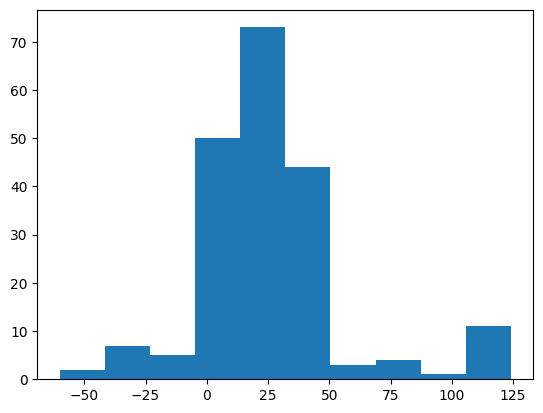

In [42]:
plt.hist(fit_t0)

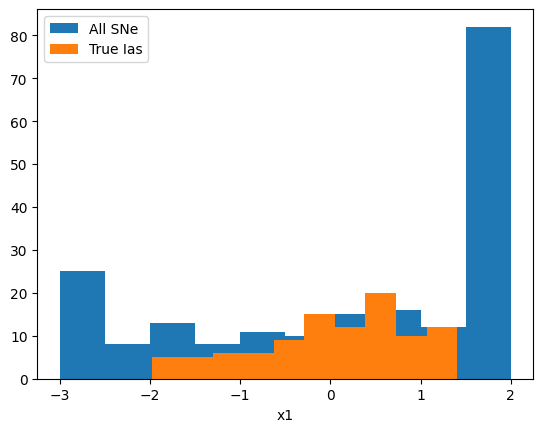

In [43]:
plt.hist(fit_x1, label="All SNe")
plt.hist([sn.true_params['x1'] for sn in true_ia_sne], label="True Ias")
plt.xlabel("x1")
plt.legend()

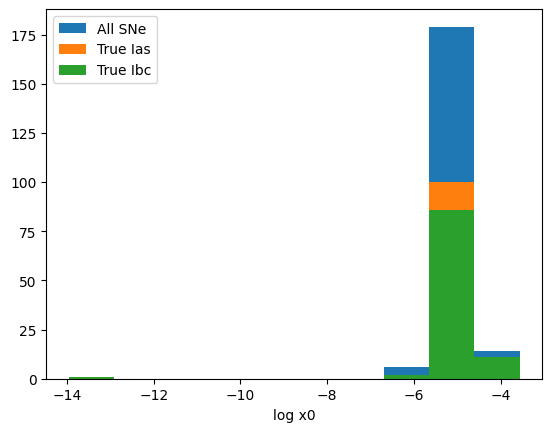

In [44]:
_, bins, _ = plt.hist(np.log10(fit_x0), label="All SNe")
plt.hist(np.log10([sn.true_params['x0'] for sn in true_ia_sne]), label="True Ias", bins=bins)
plt.hist(np.log10([sn.ia_fit['x0'] for sn in true_ibc_sne]), label="True Ibc", bins=bins)

plt.xlabel("log x0")
plt.legend()

In [45]:
ibc_mask = [sn in true_ibc_sne for sn in all_sne]

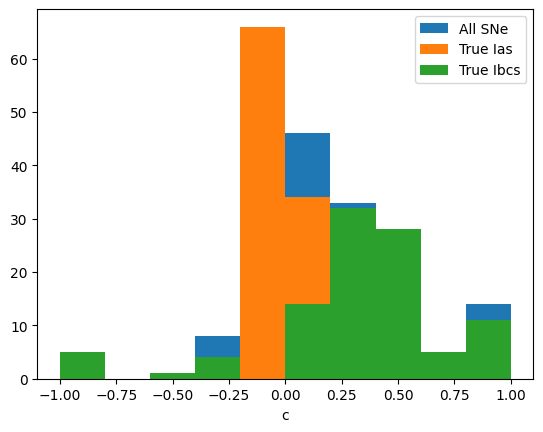

In [46]:
_, bins, _ = plt.hist(fit_c, label="All SNe")
plt.hist([sn.true_params['c'] for sn in true_ia_sne], label="True Ias", bins=bins)
plt.hist(fit_c[(len(fit_c)//2):len(fit_c)], label="True Ibcs", bins=bins)

plt.xlabel("c")
plt.legend()

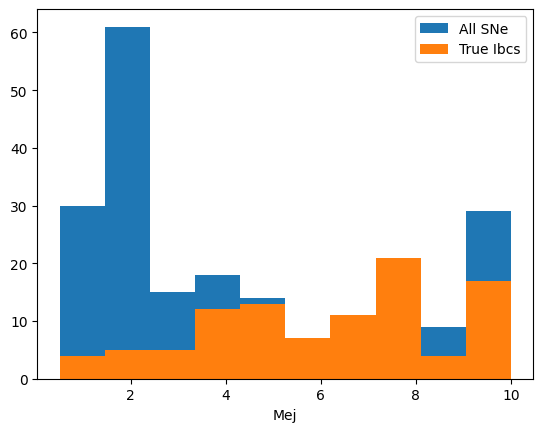

In [47]:
_, bins, _ = plt.hist(fit_mej, label="All SNe")
plt.hist([sn.true_params['mej'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

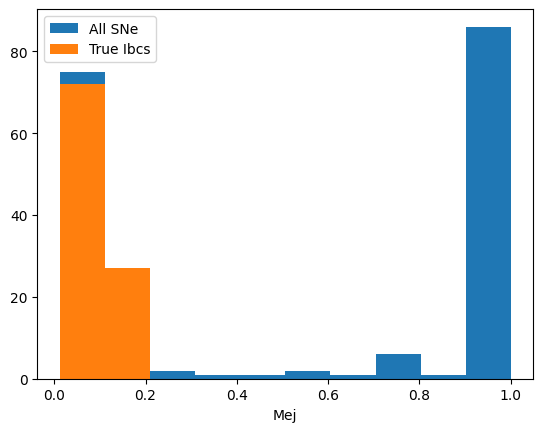

In [48]:
_, bins, _ = plt.hist(fit_fni, label="All SNe")
plt.hist([sn.true_params['fni'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

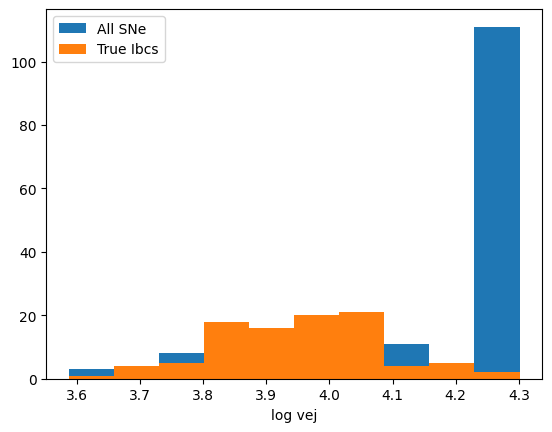

In [49]:
_, bins, _ = plt.hist(np.log10(fit_vej), label="All SNe")
plt.hist(np.log10([sn.true_params['vej'] for sn in true_ibc_sne]), label="True Ibcs", bins=bins)
plt.xlabel("log vej")
plt.legend()